# Learning Discrete-Time Estimation and Control with Transformers: Baselines

In [1]:
from kalman_filter import *
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import matplotlib.pyplot as plt

rng = np.random.default_rng()

T = 250 # how long to simulate the trajectory
CUT = 5 # cutoff the first 5 elements of the trajectory
state_dim = 2 # Dimension of the state-space
input_dim = 1 # Dimension of inputs
obs_dim = 2
# NUM_TRAJ = 100 # number of trajectories to simulate

import time

# State Estimation: Continuous State Space 

## Generate Trajectories that follow a fixed path on the unit circle

In [2]:
theta = 1/360*2*np.pi # one degree

A = np.array([[np.cos(theta), -np.sin(theta)], # state transition matrix
              [np.sin(theta),  np.cos(theta)]]) # moving around a circle at 1 deg per timestep
B = np.array([[0.5], [0.7]]) # input transformation
# B = np.zeros(shape=(state_dim, input_dim)) # ignore inputs for now
C = np.eye(obs_dim, state_dim) # Using identity map for now
Q = 0.001*np.eye(state_dim) # Covariance matrix of process noise
R = 0.01*np.eye(obs_dim) # Covariance matrix of sensor noise
x0 = np.array([1.0, 0.0], dtype=np.float64) # starting state
u_seq = 0.05 * (rng.random(size=(T, input_dim))*2 - 1)

In [3]:
traj = np.zeros(shape=(T, state_dim))
meas = np.zeros(shape=(T, obs_dim))
pure_poses = np.zeros(shape=(T, obs_dim))
x = x0
pure_pos = x0
pos_no_inputs = x0

for i in range(T):
    u_t = u_seq[i]
    w_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=Q) # process noise
    x = A @ x + w_t + B @ u_t # inputs
    v_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=R) # sensor noise
    pure_pos = A @ pure_pos + B @ u_t # original pose, without any process noise or sensor noise
    y = C @ x + v_t
    traj[i] = x
    meas[i] = y
    pure_poses[i] = pure_pos

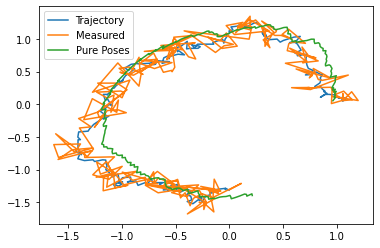

In [4]:
# plot trajectory and noisy measurements

plt.figure()
#fig, ax = plt.subplots()
linetraj = plt.plot(traj[CUT:,0], traj[CUT:,1], label='Trajectory')
linemeas = plt.plot(meas[CUT:,0], meas[CUT:,1], label='Measured')
linepure = plt.plot(pure_poses[CUT:,0], pure_poses[CUT:,1], label='Pure Poses')
plt.legend()
plt.show()

## 1. Kalman Filtering using known A, B to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

Converged in 18 iterations


<Figure size 432x288 with 0 Axes>

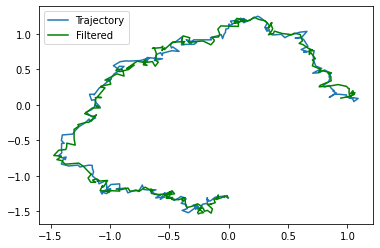

Sum of Squared Error 1.2479175037173


In [5]:
kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
fltr = kinematics_forward.simulate(meas, u_seq)

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
linefltr, = ax.plot(fltr[CUT:,0], fltr[CUT:,1], label="Filtered", color='g')
plt.legend()
plt.show()

err_fltr = np.linalg.norm(fltr[CUT:,:] - traj[CUT:,:])**2
print("Sum of Squared Error", err_fltr)

### 1b. Kalman Filter with pure steady state gains

Converged in 0 iterations


<Figure size 432x288 with 0 Axes>

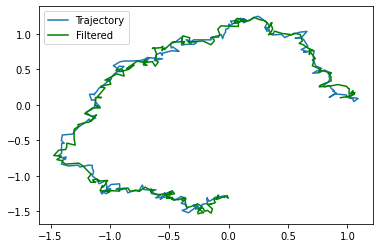

Sum of Squared Error 1.2495212219011351


In [6]:
kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
kinematics_forward.run_till_ss()
fltr_ss = kinematics_forward.simulate(meas, u_seq)

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
#linemeas, = ax.plot(meas[:,0], meas[:,1], label="Measured")
linefltr, = ax.plot(fltr_ss[CUT:,0], fltr_ss[CUT:,1], label="Filtered", color='g')
plt.legend()
plt.show()

err_fltr_ss = np.linalg.norm(fltr_ss[CUT:,:] - traj[CUT:,:])**2
print("Sum of Squared Error", err_fltr_ss)

## 2. Least Squares System ID + Kalman Filtering

###  2a.i. Update on the identified system at each timestep

In [7]:
# Use the same data as before, but now no peeking on what are the actual A, B matrices
A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)
id_fltr = np.zeros(shape=(T,state_dim))
for t in range(T):
    A_found, B_found = system_id(meas, t, x0, u_seq)
    
    kinematics.A = A_found
    kinematics.B = B_found
    kinematics.predict(u_seq[t])
    kinematics.update(meas[t])
    id_fltr[t] = kinematics.state

<Figure size 432x288 with 0 Axes>

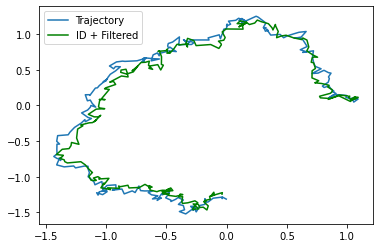

Sum of Squared Error 2.9554029137833764


In [8]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
#linemeas, = ax.plot(meas[:,0], meas[:,1], label="Measured")
linefltr, = ax.plot(id_fltr[CUT:,0], id_fltr[CUT:,1], label="ID + Filtered", color='g')
plt.legend()
plt.show()

err_id_fltr = np.linalg.norm(id_fltr[CUT:,:] - traj[CUT:,:])**2
print("Sum of Squared Error", err_id_fltr)

# 2a.ii. Kalman filter for each timestep simulated from the start

In [9]:
id_fltr_sim = np.zeros(shape=(T,state_dim))
for t in range(1, T):
    A_found, B_found = system_id(meas, t, x0, u_seq)
    kinematics = KFilter(A_found, B_found, C, Q, R, x0)
    id_fltr_sim[t] = kinematics.simulate(meas[:t], u_seq[:t])[-1]

Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

<Figure size 432x288 with 0 Axes>

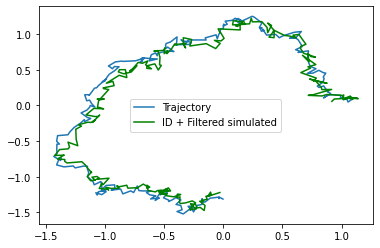

Sum of Squared Error 3.5294780436859354


In [10]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory") # cut out first point since it starts at the origin
#linemeas, = ax.plot(meas[CUT:,0], meas[CUT:,1], label="Measured")
linefltr, = ax.plot(id_fltr_sim[CUT:,0], id_fltr_sim[CUT:,1], label="ID + Filtered simulated", color='g')
plt.legend()
plt.show()

err_fltr_sim = np.linalg.norm(id_fltr_sim[CUT:, :] - traj[CUT:, :])**2
print("Sum of Squared Error", err_fltr_sim)

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 
(Just use the identity for now, later can try to learn C' as well)

In [12]:
kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
kinematics.fit(meas, u_seq, eps=2.5, maxIt=float('inf'))
learned_kf_sim = kinematics.simulate(meas, u_seq)

Iteration 10 : Loss 91.2954161505697
Iteration 20 : Loss 45.26237073947356
Iteration 30 : Loss 23.084660937998454
Iteration 40 : Loss 11.75761141305775
Iteration 50 : Loss 11.268600323666936
Iteration 60 : Loss 10.694556028076484
Iteration 70 : Loss 10.111235162193928
Iteration 80 : Loss 9.901940761039874
Iteration 90 : Loss 9.605584444884155
Iteration 100 : Loss 9.35892833252476
Iteration 110 : Loss 9.115063616168452
Iteration 120 : Loss 8.883942323450265
Iteration 130 : Loss 8.670128508295315
Iteration 140 : Loss 8.473652025624643
Iteration 150 : Loss 8.296658610632603
Iteration 160 : Loss 8.138238272506586
Iteration 170 : Loss 7.99689301493638
Iteration 180 : Loss 7.870599000275155
Iteration 190 : Loss 7.757368712260712
Iteration 200 : Loss 7.655333156395413
Iteration 210 : Loss 7.562846898142045
Iteration 220 : Loss 7.478503737999816
Iteration 230 : Loss 7.401125061483989
Iteration 240 : Loss 7.329729198214838
Iteration 250 : Loss 7.263500209311932
Iteration 260 : Loss 7.2017592070

Iteration 2090 : Loss 4.581911112524419
Iteration 2100 : Loss 4.576162240630357
Iteration 2110 : Loss 4.570451532905914
Iteration 2120 : Loss 4.564778805551041
Iteration 2130 : Loss 4.55914387402155
Iteration 2140 : Loss 4.553546552999769
Iteration 2150 : Loss 4.547986656369247
Iteration 2160 : Loss 4.542463997193274
Iteration 2170 : Loss 4.5369783876972924
Iteration 2180 : Loss 4.531529639254826
Iteration 2190 : Loss 4.526117562376901
Iteration 2200 : Loss 4.520741966704756
Iteration 2210 : Loss 4.515402661005721
Iteration 2220 : Loss 4.510099453172133
Iteration 2230 : Loss 4.504832150223069
Iteration 2240 : Loss 4.499600558308848
Iteration 2250 : Loss 4.494404482718121
Iteration 2260 : Loss 4.489243727887434
Iteration 2270 : Loss 4.484118097413062
Iteration 2280 : Loss 4.479027394065123
Iteration 2290 : Loss 4.473971419803686
Iteration 2300 : Loss 4.46894997579689
Iteration 2310 : Loss 4.463962862440832
Iteration 2320 : Loss 4.459009879381246
Iteration 2330 : Loss 4.454090825536671
I

Iteration 4140 : Loss 3.9339084316129767
Iteration 4150 : Loss 3.9322659335190786
Iteration 4160 : Loss 3.9306310077656117
Iteration 4170 : Loss 3.9290035997703043
Iteration 4180 : Loss 3.927383655629544
Iteration 4190 : Loss 3.925771122110809
Iteration 4200 : Loss 3.9241659466450782
Iteration 4210 : Loss 3.9225680773193408
Iteration 4220 : Loss 3.920977462869081
Iteration 4230 : Loss 3.9193940526708526
Iteration 4240 : Loss 3.917817796734869
Iteration 4250 : Loss 3.916248645697607
Iteration 4260 : Loss 3.9146865508145154
Iteration 4270 : Loss 3.9131314639526824
Iteration 4280 : Loss 3.911583337583605
Iteration 4290 : Loss 3.910042124775974
Iteration 4300 : Loss 3.9085077791885157
Iteration 4310 : Loss 3.906980255062849
Iteration 4320 : Loss 3.905459507216425
Iteration 4330 : Loss 3.9039454910354716
Iteration 4340 : Loss 3.902438162467999
Iteration 4350 : Loss 3.9009374780168686
Iteration 4360 : Loss 3.8994433947328613
Iteration 4370 : Loss 3.8979558702078645
Iteration 4380 : Loss 3.89

Iteration 6170 : Loss 3.710706188280611
Iteration 6180 : Loss 3.7100173103409317
Iteration 6190 : Loss 3.7093315454723212
Iteration 6200 : Loss 3.7086488831036712
Iteration 6210 : Loss 3.70796931268218
Iteration 6220 : Loss 3.7072928236731557
Iteration 6230 : Loss 3.706619405559887
Iteration 6240 : Loss 3.7059490478434363
Iteration 6250 : Loss 3.705281740042534
Iteration 6260 : Loss 3.7046174716934077
Iteration 6270 : Loss 3.7039562323496993
Iteration 6280 : Loss 3.7032980115823033
Iteration 6290 : Loss 3.7026427989792925
Iteration 6300 : Loss 3.7019905841458214
Iteration 6310 : Loss 3.7013413567040154
Iteration 6320 : Loss 3.7006951062929354
Iteration 6330 : Loss 3.7000518225684664
Iteration 6340 : Loss 3.699411495203297
Iteration 6350 : Loss 3.698774113886847
Iteration 6360 : Loss 3.6981396683252465
Iteration 6370 : Loss 3.697508148241276
Iteration 6380 : Loss 3.6968795433743744
Iteration 6390 : Loss 3.696253843480591
Iteration 6400 : Loss 3.6956310383326043
Iteration 6410 : Loss 3.6

Iteration 8200 : Loss 3.6214865511739567
Iteration 8210 : Loss 3.621240568298669
Iteration 8220 : Loss 3.6209959976647186
Iteration 8230 : Loss 3.620752833591379
Iteration 8240 : Loss 3.620511070422932
Iteration 8250 : Loss 3.6202707025285363
Iteration 8260 : Loss 3.6200317243020685
Iteration 8270 : Loss 3.6197941301619507
Iteration 8280 : Loss 3.619557914551022
Iteration 8290 : Loss 3.6193230719363534
Iteration 8300 : Loss 3.6190895968090904
Iteration 8310 : Loss 3.6188574836842875
Iteration 8320 : Loss 3.618626727100753
Iteration 8330 : Loss 3.6183973216208574
Iteration 8340 : Loss 3.6181692618303845
Iteration 8350 : Loss 3.617942542338349
Iteration 8360 : Loss 3.6177171577768186
Iteration 8370 : Loss 3.6174931028007395
Iteration 8380 : Loss 3.6172703720877606
Iteration 8390 : Loss 3.6170489603380562
Iteration 8400 : Loss 3.6168288622741374
Iteration 8410 : Loss 3.6166100726406696
Iteration 8420 : Loss 3.6163925862043005
Iteration 8430 : Loss 3.61617639775345
Iteration 8440 : Loss 3.

Iteration 10220 : Loss 3.5939867562714616
Iteration 10230 : Loss 3.593932803166073
Iteration 10240 : Loss 3.5938793990353304
Iteration 10250 : Loss 3.593826540342118
Iteration 10260 : Loss 3.593774223555864
Iteration 10270 : Loss 3.5937224451526055
Iteration 10280 : Loss 3.5936712016150207
Iteration 10290 : Loss 3.5936204894325185
Iteration 10300 : Loss 3.5935703051012564
Iteration 10310 : Loss 3.5935206451241952
Iteration 10320 : Loss 3.5934715060111833
Iteration 10330 : Loss 3.593422884278976
Iteration 10340 : Loss 3.593374776451306
Iteration 10350 : Loss 3.5933271790589347
Iteration 10360 : Loss 3.5932800886397
Iteration 10370 : Loss 3.5932335017385917
Iteration 10380 : Loss 3.593187414907785
Iteration 10390 : Loss 3.5931418247067017
Iteration 10400 : Loss 3.5930967277020613
Iteration 10410 : Loss 3.593052120467953
Iteration 10420 : Loss 3.593007999585869
Iteration 10430 : Loss 3.5929643616447935
Iteration 10440 : Loss 3.5929212032412168
Iteration 10450 : Loss 3.5928785209792187
Ite

Iteration 12200 : Loss 3.590054452115788
Iteration 12210 : Loss 3.590052321419439
Iteration 12220 : Loss 3.5900502448259304
Iteration 12230 : Loss 3.5900482212414975
Iteration 12240 : Loss 3.5900462495875085
Iteration 12250 : Loss 3.5900443288003667
Iteration 12260 : Loss 3.5900424578314696
Iteration 12270 : Loss 3.5900406356471204
Iteration 12280 : Loss 3.5900388612284653
Iteration 12290 : Loss 3.5900371335714154
Iteration 12300 : Loss 3.5900354516865733
Iteration 12310 : Loss 3.5900338145991575
Iteration 12320 : Loss 3.5900322213489164
Iteration 12330 : Loss 3.590030670990043
Iteration 12340 : Loss 3.5900291625911063
Iteration 12350 : Loss 3.5900276952349564
Iteration 12360 : Loss 3.5900262680186295
Iteration 12370 : Loss 3.5900248800532704
Iteration 12380 : Loss 3.590023530464031
Iteration 12390 : Loss 3.5900222183899992
Iteration 12400 : Loss 3.5900209429840744
Iteration 12410 : Loss 3.590019703412885
Iteration 12420 : Loss 3.5900184988566957
Iteration 12430 : Loss 3.59001732850930

Iteration 14180 : Loss 3.5899852026626258
Iteration 14190 : Loss 3.589987366188749
Iteration 14200 : Loss 3.5899834609084538
Iteration 14210 : Loss 3.589983577450865
Iteration 14220 : Loss 3.589983301576879
Iteration 14230 : Loss 3.5899831715880652
Iteration 14240 : Loss 3.589983190942677
Iteration 14250 : Loss 3.589983173120212
Iteration 14260 : Loss 3.5899831660443944
Iteration 14270 : Loss 3.58998316564612
Iteration 14280 : Loss 3.589983165532299
Iteration 14290 : Loss 3.589983165277282
Iteration 14300 : Loss 3.5899831650762444
Iteration 14310 : Loss 3.5899831649397043
Iteration 14320 : Loss 3.5899831648406404
Iteration 14330 : Loss 3.5899831647625664
Iteration 14340 : Loss 3.5899831646978813
Iteration 14350 : Loss 3.5899831646425375
Iteration 14360 : Loss 3.5899831645940217
Iteration 14370 : Loss 3.5899831645509153
Iteration 14380 : Loss 3.5899831645125198
Iteration 14390 : Loss 3.5899831644781997
Iteration 14400 : Loss 3.589983164447389
Iteration 14410 : Loss 3.5899831644196634
It

Iteration 16160 : Loss 3.589983164174762
Iteration 16170 : Loss 3.5899831657011227
Iteration 16180 : Loss 3.58998363417001
Iteration 16190 : Loss 3.5902153749563976
Iteration 16200 : Loss 3.590539179062591
Iteration 16210 : Loss 3.5901259314456744
Iteration 16220 : Loss 3.589985757411101
Iteration 16230 : Loss 3.589992908775012
Iteration 16240 : Loss 3.5899912466366337
Iteration 16250 : Loss 3.5899848486379877
Iteration 16260 : Loss 3.5899832550243755
Iteration 16270 : Loss 3.5899831859275615
Iteration 16280 : Loss 3.589983199288823
Iteration 16290 : Loss 3.589983185711397
Iteration 16300 : Loss 3.589983173715429
Iteration 16310 : Loss 3.589983168061865
Iteration 16320 : Loss 3.5899831661160144
Iteration 16330 : Loss 3.589983165624776
Iteration 16340 : Loss 3.5899831653724807
Iteration 16350 : Loss 3.5899831650137175
Iteration 16360 : Loss 3.5899831647342837
Iteration 16370 : Loss 3.58998316460111
Iteration 16380 : Loss 3.5899831644936393
Iteration 16390 : Loss 3.58998316441531
Iterati

Iteration 18140 : Loss 3.5899831641606323
Iteration 18150 : Loss 3.589983164159466
Iteration 18160 : Loss 3.589983164158591
Iteration 18170 : Loss 3.589983164158055
Iteration 18180 : Loss 3.5899831641760986
Iteration 18190 : Loss 3.589983169663331
Iteration 18200 : Loss 3.589986073198626
Iteration 18210 : Loss 3.591414239330112
Iteration 18220 : Loss 3.590239943589431
Iteration 18230 : Loss 3.5901572166950664
Iteration 18240 : Loss 3.5899856713113127
Iteration 18250 : Loss 3.590006995027645
Iteration 18260 : Loss 3.589983377265051
Iteration 18270 : Loss 3.5899856407050206
Iteration 18280 : Loss 3.5899838371124067
Iteration 18290 : Loss 3.5899831884090476
Iteration 18300 : Loss 3.589983270271566
Iteration 18310 : Loss 3.589983220564025
Iteration 18320 : Loss 3.5899831801167763
Iteration 18330 : Loss 3.589983169491545
Iteration 18340 : Loss 3.5899831672838447
Iteration 18350 : Loss 3.5899831663814066
Iteration 18360 : Loss 3.589983165768745
Iteration 18370 : Loss 3.5899831653380962
Itera

Iteration 20120 : Loss 3.591864671802814
Iteration 20130 : Loss 3.5906807766893682
Iteration 20140 : Loss 3.589984715533827
Iteration 20150 : Loss 3.5900326252275767
Iteration 20160 : Loss 3.59001315378009
Iteration 20170 : Loss 3.589985221294773
Iteration 20180 : Loss 3.5899845256464835
Iteration 20190 : Loss 3.5899845129187926
Iteration 20200 : Loss 3.589983198635043
Iteration 20210 : Loss 3.589983347887056
Iteration 20220 : Loss 3.589983183913592
Iteration 20230 : Loss 3.5899831952496233
Iteration 20240 : Loss 3.5899831714826043
Iteration 20250 : Loss 3.5899831718241697
Iteration 20260 : Loss 3.589983168419433
Iteration 20270 : Loss 3.5899831669330613
Iteration 20280 : Loss 3.589983166290811
Iteration 20290 : Loss 3.5899831657225905
Iteration 20300 : Loss 3.5899831653094068
Iteration 20310 : Loss 3.589983165021846
Iteration 20320 : Loss 3.58998316481235
Iteration 20330 : Loss 3.5899831646555915
Iteration 20340 : Loss 3.589983164537165
Iteration 20350 : Loss 3.5899831644472644
Iterat

KeyboardInterrupt: 

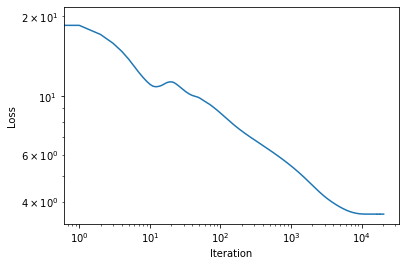

In [13]:
plt.figure()
plt.plot(kinematics.losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

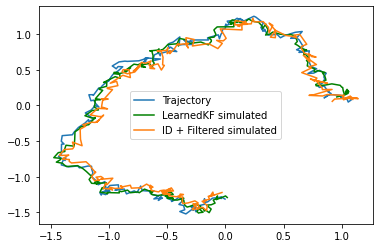

In [15]:
learned_kf_sim = kinematics.simulate(meas, u_seq)

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
linefltr, = ax.plot(learned_kf_sim[CUT:,0], learned_kf_sim[CUT:,1], label="LearnedKF simulated", color='g')
lineopt, = ax.plot(id_fltr_sim[CUT:,0], id_fltr_sim[CUT:,1], label="ID + Filtered simulated")
plt.legend()
plt.show()

In [ ]:
print("Aprime", kinematics.Aprime)
print("Aprime true", A @ (np.eye(state_dim) - kinematics_forward.K @ C))
print("Bprime", kinematics.Bprime)
print("Bprime true", B)
print("Gprime", kinematics.Gprime)
print("Gprime true", A @ kinematics_forward.K)